<a href="https://colab.research.google.com/github/vibhorrrrr/AI-ML-DS/blob/main/Diabetes_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diabetes-prediction-from-medicalrecords:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F67084%2F7452899%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240129%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240129T213501Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8b76c649640a2762fdbb2c3be9ac7cb70aebd3ca96ace2002125d3336eb9e737af0b15e437b65cfb37317f16b222c5b2f77504a04483d3fd45ca7edede9c661e17a3cdb91a076cd1c4349e8fc384749c9677284a35da107cc2325fdfd7f7f028efa0d353387a66845dffd7031a66464fb1df6cb525cab107096e73758cac349d18a72f68e99c372ae86c6b333153005d5896bf604415f8a36f34d61500469146462cb7fd6ea8cfa186ddd46ec08c3a5478e1a4014c0ad9126e230e79c16a321860f04d93753271dfb8dec61a17e89bf92b8ee4e6281b742416165eda7a168b93f87a73cb9b81e059fa3c73c9da8cb6744822e03ebab0ff421a38a9e82611fcc1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 12170 bytes downloaded
Downloaded and uncompressed: diabetes-prediction-from-medicalrecords
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-prediction-from-medicalrecords/test.csv
/kaggle/input/diabetes-prediction-from-medicalrecords/train.csv
/kaggle/input/diabetes-prediction-from-medicalrecords/sample_submission.csv


# **Importing the libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras

# **Reading the data**

In [4]:
df = pd.read_csv('/kaggle/input/diabetes-prediction-from-medicalrecords/train.csv')

# **Drop the 'Id' column**

In [5]:
df.drop(columns='Id', inplace=True)

# **Explore the dataset**

In [6]:
print('DataFrame overall info:')
display(df.info())

print('\nDataFrame null values:')
display(df.isna().sum())

print('\nDataFrame duplicate values:')
display(df.duplicated().sum())

print('\nDataFrame statistical info:')
display(df.describe())

DataFrame overall info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               550 non-null    int64  
 1   Glucose                   550 non-null    int64  
 2   BloodPressure             550 non-null    int64  
 3   SkinThickness             550 non-null    int64  
 4   Insulin                   550 non-null    int64  
 5   BMI                       550 non-null    float64
 6   DiabetesPedigreeFunction  550 non-null    float64
 7   Age                       550 non-null    int64  
 8   Outcome                   550 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 38.8 KB


None


DataFrame null values:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


DataFrame duplicate values:


0


DataFrame statistical info:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,4.034545,121.560000,69.381818,20.014545,80.141818,31.902000,0.466582,33.590909,0.354545
std,3.447325,30.551206,19.036147,15.898006,115.429640,7.822178,0.320054,12.054140,0.478811
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,62.000000,0.000000,0.000000,27.200000,0.239250,24.000000,0.000000
50%,3.000000,119.000000,72.000000,22.000000,22.500000,32.000000,0.375000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,128.750000,36.500000,0.628250,41.000000,1.000000
max,17.000000,197.000000,122.000000,63.000000,846.000000,59.400000,2.420000,81.000000,1.000000


# **Plot some columns**

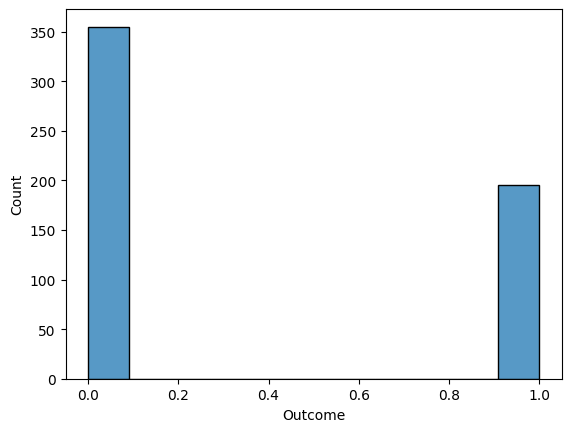

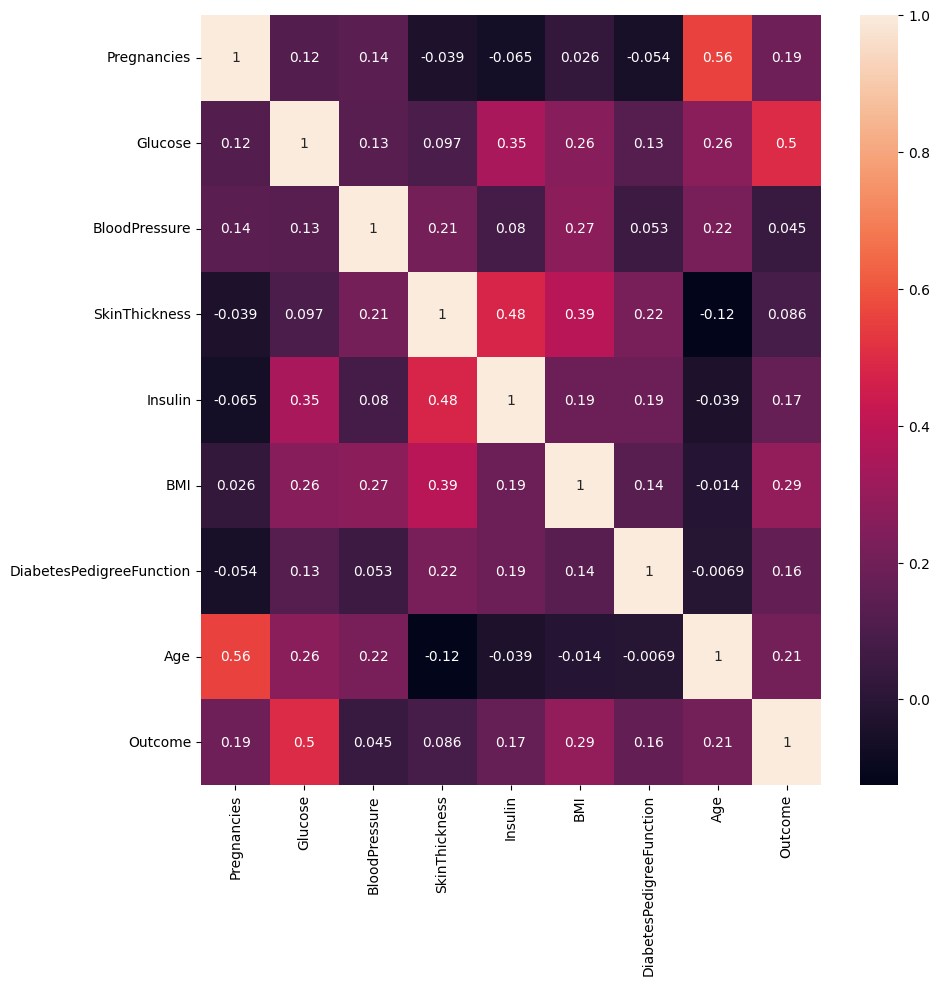

In [7]:
sns.histplot(df['Outcome'])
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

# **Preprocessing**

In [8]:
X = df.drop(columns='Outcome')
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# **Use SMOTE for handling class imbalance**

In [9]:
smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# **Random Forest Classifier**

In [10]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0, n_jobs=2)

# **Hyperparameter tuning using GridSearchCV**

In [11]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=4, n_jobs=2)
grid_search.fit(X_scaled_train, y_train)

best_model = grid_search.best_estimator_

# **Model evaluation on test set**

In [12]:
predictions = best_model.predict(X_scaled_test)
cm = confusion_matrix(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

print(f'Best parameters from GridSearchCV: {grid_search.best_params_}')
print(f'Best F1 Score from GridSearchCV: {grid_search.best_score_}')
print(f'Confusion matrix:\n{cm}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

Best parameters from GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 Score from GridSearchCV: 0.8413780960083107
Confusion matrix:
[[80 25]
 [16 44]]
F1 Score: 0.6821705426356589
ROC AUC Score: 0.7476190476190476


# **Neural Network using TensorFlow/Keras**

In [13]:
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(8,), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[keras.metrics.Precision()])

# **Fitting the model and evaluating on the test set**

In [14]:
model.fit(X_scaled_train, y_train, epochs=100, batch_size=32, validation_split=0.5, verbose=0)
test_loss, test_precision = model.evaluate(X_scaled_test, y_test)
print(f'Test Precision: {test_precision}')

6/6 [==============================] - 0s 6ms/step - loss: 0.5109 - precision: 0.7234
Test Precision: 0.7234042286872864


# **XGBoost Classifier**

In [15]:
xgb_model = XGBClassifier(n_estimators=3000, learning_rate=0.2, max_depth=5, random_state=0)
xgb_model.fit(X_scaled_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=3000, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

# **Model evaluation on test set**

In [16]:
xgb_predictions = xgb_model.predict(X_scaled_test)
xgb_cm = confusion_matrix(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)
xgb_roc_auc = roc_auc_score(y_test, xgb_predictions)

print(f'XGBoost Confusion matrix:\n{xgb_cm}')
print(f'XGBoost F1 Score: {xgb_f1}')
print(f'XGBoost ROC AUC Score: {xgb_roc_auc}')

XGBoost Confusion matrix:
[[77 28]
 [18 42]]
XGBoost F1 Score: 0.6461538461538462
XGBoost ROC AUC Score: 0.7166666666666668


# **It can be seen that Random Forest works the best, hence using that, the code altogether is:-**

In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras

# Loading data
df_train = pd.read_csv('/kaggle/input/diabetes-prediction-from-medicalrecords/train.csv')

# Droppingg the 'Id' column
df_train = df_train.drop(columns='Id')

# Separateing features and target variable
X = df_train.drop(columns='Outcome')
y = df_train['Outcome']

# Applying SMOTE for handling class imbalance
smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scaling the features
scaler = MinMaxScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Training Random Forest
rfc = RandomForestClassifier(max_features=2, n_estimators=100, max_depth=3, n_jobs=2)
rfc.fit(X_scaled_train, y_train)

# Evaluation
crossval = cross_val_score(rfc, X_scaled_train, y_train, cv=4, n_jobs=2, scoring='f1')
print("Cross-Validation F1 Scores:", crossval)

predictions = rfc.predict(X_scaled_test)
cm = confusion_matrix(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

print(f'Confusion matrix:\n{cm}')
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

# Neural Network Model
tf.random.set_seed(42)
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(X_scaled_train.shape[1],), activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_scaled_train, y_train, epochs=100, batch_size=32, validation_split=0.5)

# Evaluating Neural Network on Test Set
test_loss, test_acc = model.evaluate(X_scaled_test, y_test)
print(f'Neural Network Test Accuracy: {test_acc}')

# Loading and preprocessing the test data
df_test = pd.read_csv('/kaggle/input/diabetes-prediction-from-medicalrecords/test.csv')
X_test_final = df_test.drop(columns=['Id'])
X_scaled_test_final = scaler.transform(X_test_final)

# Predictions using Random Forest
binary_predictions_final = rfc.predict(X_scaled_test_final)

# Saving to a CSV file
submission = pd.read_csv('/kaggle/input/diabetes-prediction-from-medicalrecords/sample_submission.csv')
submission['Outcome'] = binary_predictions_final
submission.to_csv('submission_diabetes.csv', index=False)


Cross-Validation F1 Scores: [0.81290323 0.74172185 0.78666667 0.80794702]
Confusion matrix:
[[58 16]
 [12 56]]
F1 Score: 0.7999999999999999
ROC AUC Score: 0.8036565977742448
Epoch 1/100
9/9 [==============================] - 1s 31ms/step - loss: 0.6940 - accuracy: 0.4613 - val_loss: 0.6927 - val_accuracy: 0.4859
Epoch 2/100
9/9 [==============================] - 0s 8ms/step - loss: 0.6886 - accuracy: 0.5352 - val_loss: 0.6923 - val_accuracy: 0.4859
Epoch 3/100
9/9 [==============================] - 0s 8ms/step - loss: 0.6916 - accuracy: 0.5282 - val_loss: 0.6913 - val_accuracy: 0.4859
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 0.6801 - accuracy: 0.5282 - val_loss: 0.6895 - val_accuracy: 0.4859
Epoch 5/100
9/9 [==============================] - 0s 10ms/step - loss: 0.6788 - accuracy: 0.5458 - val_loss: 0.6871 - val_accuracy: 0.4859
Epoch 6/100
9/9 [==============================] - 0s 9ms/step - loss: 0.6767 - accuracy: 0.5775 - val_loss: 0.6859 - val_accurac

In [37]:
submission.head(10)

,Id,Outcome
0,0,1
1,2,0
2,4,1
3,6,0
4,15,0
5,18,0
6,20,1
7,22,1
8,40,1
9,41,1
